# Table of Contents
* [158222 Assignment 4](#158222-Assignment-4)
	* &nbsp;
		* [Prediction model for NZ retail petrol and diesel price](#Prediction-model-for-NZ-retail-petrol-and-diesel-price)
	* [Introduction](#Introduction)
	* [Preparing the data](#Preparing-the-data)
	* [Examine the Data](#Examine-the-Data)
	* [Auto-correlations](#Auto-correlations)
	* [Time Series modeling](#Time-Series-modeling)
	* [Analyzing the Residuals](#Analyzing-the-Residuals)
		* &nbsp;
			* &nbsp;
				* [We can see the qq plot for diesel and petrol almost identitcal. Both Q-Q plot shows that residual of the prediction and the actual value are very small.](#We-can-see-the-qq-plot-for-diesel-and-petrol-almost-identitcal.-Both-Q-Q-plot-shows-that-residual-of-the-prediction-and-the-actual-value-are-very-small.)
	* [Model Autocorrelation](#Model-Autocorrelation)
		* &nbsp;
			* &nbsp;
				* [By using log transformation , the autocorrelation of the prediction model is quite goode.](#By-using-log-transformation-,-the-autocorrelation-of-the-prediction-model-is-quite-goode.)
	* [Prediction](#Prediction)
	* [Calculate Forecast Error](#Calculate-Forecast-Error)
		* &nbsp;
			* [MFE slightly less than zero, model showed a little bit trend to over-forcast ,however it is between -4 to 4 range it means  model is working correctly.And MAE is significantly small it would indicate a prety good fit.](#MFE-slightly-less-than-zero,-model-showed-a-little-bit-trend-to-over-forcast-,however-it-is-between--4-to-4-range-it-means--model-is-working-correctly.And-MAE-is-significantly-small-it-would-indicate-a-prety-good-fit.)
			* [From above summary we can see that the mdoel_petrol fit well to the dataset. Because the Akaike information criterion(AIC), Bayesian information criterion(BIC) and Hannan–Quinn information criterion (HQIC) is quite small.](#From-above-summary-we-can-see-that-the-mdoel_petrol-fit-well-to-the-dataset.-Because-the-Akaike-information-criterion%28AIC%29,-Bayesian-information-criterion%28BIC%29-and-Hannan–Quinn-information-criterion-%28HQIC%29-is-quite-small.)
	* [Conclusion](#Conclusion)


# 158222 Assignment 4
### Prediction model for NZ retail petrol and diesel price 
Nancy Lin 14195424  Cai Gwatkin 15146508  Francis Tang 15053399  Calum De Jong 12157320

    

##  Introduction 

As we know the petrol and diesel price is time series dataset,we can use the KNN can predict the price with predictors, however, can not forces the price. Autoregressive-moving-average model is a useful tool for understanding and predict the furture value of time series.In this ipython notebook, we are going to find a good ARMA model that can fit out dataset and give an accurate prediction.

### Data Source 

In [1]:
from IPython.core.display import HTML
HTML("<iframe src=http://www.mbie.govt.nz/info-services/sectors-industries/energy/liquid-fuel-market/weekly-oil-price-monitoring width=900 height=400></iframe>")

In [2]:
from IPython.core.display import HTML
HTML("<iframe src=https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model width=900 height=400></iframe>")

In [3]:
%%javascript
require(['base/js/utils'],
function(utils) {
   utils.load_extensions('calico-spell-check', 'calico-document-tools', 'calico-cell-tools');
});

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import requests
import json
import statsmodels.api as sm

from scipy.stats import ttest_ind
from bs4 import BeautifulSoup   # Creates structured, searchable object
from time import sleep
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from pandas.tseries.offsets import *
from scipy import stats
from statsmodels.graphics.api import qqplot

pd.set_option('html', True)
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 160)

## Preparing the data

In [5]:
df_MSD_Weekly=pd.read_csv('weekly_table-31-May-2016.csv')
ts_data_petrol =pd.DataFrame(pd.TimeSeries(df_MSD_Weekly['Petrol_discounted_retail_price_NZc.p.l'].values, index=pd.to_datetime(df_MSD_Weekly.Week_ending_friday)))
ts_data_diesel=pd.DataFrame(pd.TimeSeries(df_MSD_Weekly['Diesel_discounted_retail_price_NZc.p.l'].values, index=pd.to_datetime(df_MSD_Weekly.Week_ending_friday)))
ts_data_petrol.rename(columns={0:'Petrol_discounted_retail_price_NZc.p.l'},inplace=True)
ts_data_diesel.rename(columns={0:'Diesel_discounted_retail_price_NZc.p.l'},inplace=True)


## Examine the Data

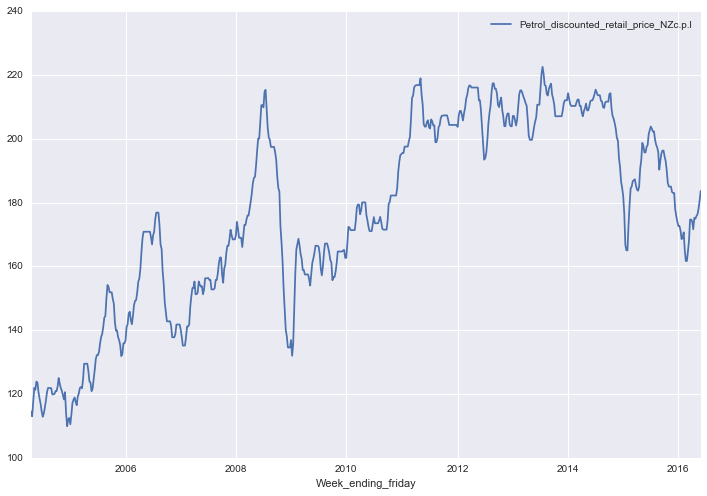

In [6]:
ts_data_petrol.plot(figsize=(12,8))

From above time series plot can can see there are some trend of the data,more irregular elements in it. However there is weak sign of seasonal and cyclic.

## Auto-correlations

Before we select a model to use we need to look at auto-correlations. Correlograms can exam the seasonal pattern of time series,which display graphically and numerically by autocorrelation function(ACF). 
Partial autocorrelations. An extension of autocorrelation, where the dependence on the intermediate elements is removed.

Auto-Correlation for Petrol


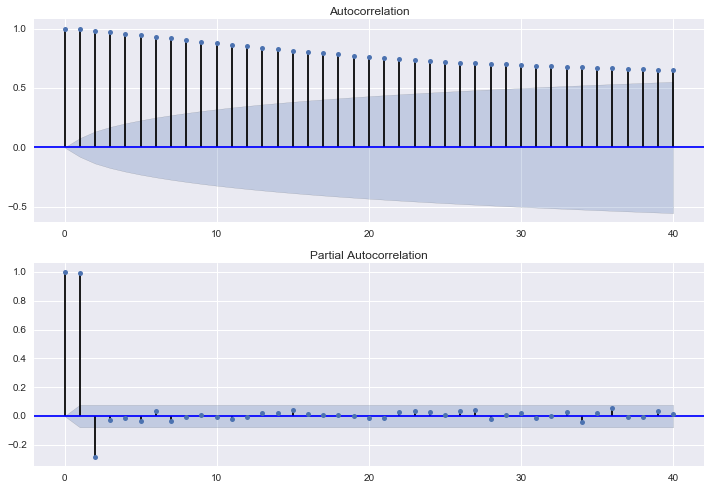

In [7]:
print "Auto-Correlation for Petrol"
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_data_petrol.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_data_petrol, lags=40, ax=ax2)

Auto-Correlation for diesel


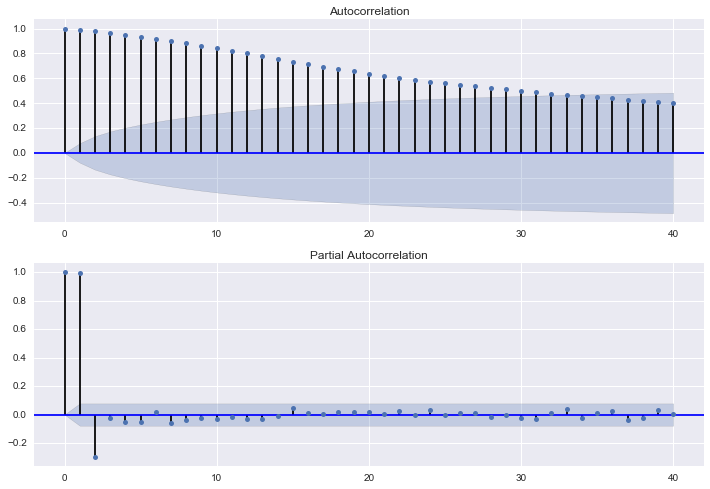

In [8]:
print "Auto-Correlation for diesel"
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_data_diesel.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_data_diesel, lags=40, ax=ax2)


The ACF shows a very slow decreasing and remains well above the significance range,it means the aotuocovariance doesn not depend on time. It indicates that the data is a non-stationary series. To remove the trend and seasonality of the data and make it stationary series.The simple way to deal with non-stationary series is to do a log transformation.

## Time Series modeling

const                                           5.085390
ar.L1.Petrol_discounted_retail_price_NZc.p.l    0.995550
ma.L1.Petrol_discounted_retail_price_NZc.p.l    0.453971
dtype: float64


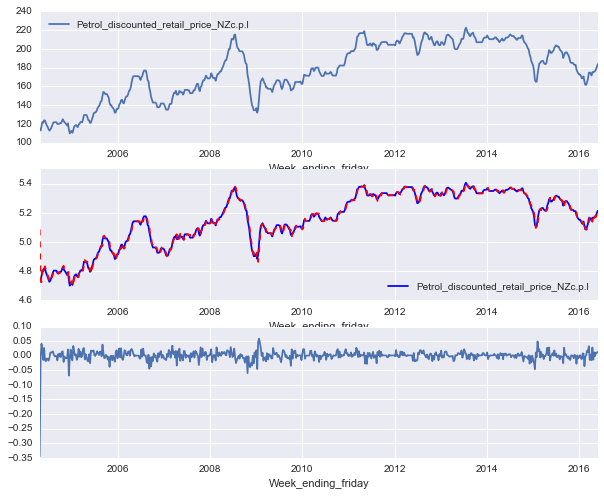

In [9]:
#Petrol
fig, axes = plt.subplots(figsize=(10,8), nrows=3)
ts_data_petrol.plot(ax=axes[0])

ts_log_data_petrol=np.log(ts_data_petrol)
ts_log_data_petrol.plot(ax=axes[1], style='b-', label='actual')

# in-sample fit
# ===================================
model_petrol = sm.tsa.ARMA(ts_log_data_petrol, (1,1)).fit()
print(model_petrol.params)

y_predPetrol = model_petrol.predict(ts_log_data_petrol.index[0].isoformat(), ts_log_data_petrol.index[-1].isoformat())
y_predPetrol.plot(ax=axes[1], style='r--', label='in-sample fit')

y_residPetrol = model_petrol.resid
y_residPetrol.plot(ax=axes[2])

const                                           4.659017
ar.L1.Diesel_discounted_retail_price_NZc.p.l    0.994819
ma.L1.Diesel_discounted_retail_price_NZc.p.l    0.425181
dtype: float64


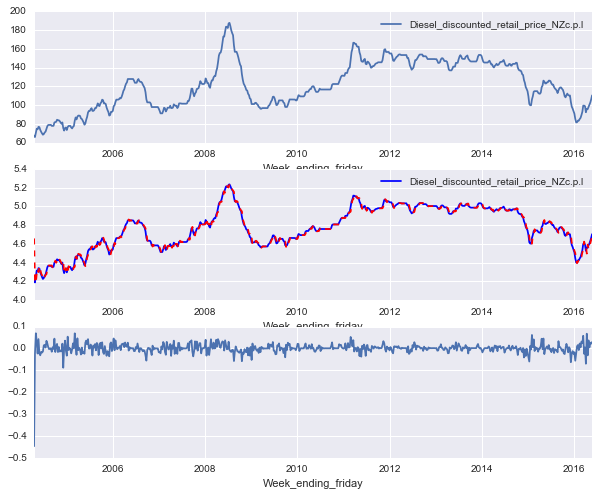

In [10]:
#Diesel
fig, axes = plt.subplots(figsize=(10,8), nrows=3)
ts_data_diesel.plot(ax=axes[0])

ts_log_data_diesel=np.log(ts_data_diesel)
ts_log_data_diesel.plot(ax=axes[1], style='b-', label='actual')

# in-sample fit
# ===================================
model_diesel = sm.tsa.ARMA(ts_log_data_diesel, order=(1,1)).fit()
print(model_diesel.params)

y_predDiesel = model_diesel.predict(ts_log_data_diesel.index[0].isoformat(), ts_log_data_diesel.index[-1].isoformat())
y_predDiesel.plot(ax=axes[1], style='r--', label='in-sample fit')

y_residDiesel = model_diesel.resid
y_residDiesel.plot(ax=axes[2])

## Analyzing the Residuals
In the following steps, we calculate the residuals, tests the null hypothesis that the residuals come from a normal distribution, and construct a qq-plot

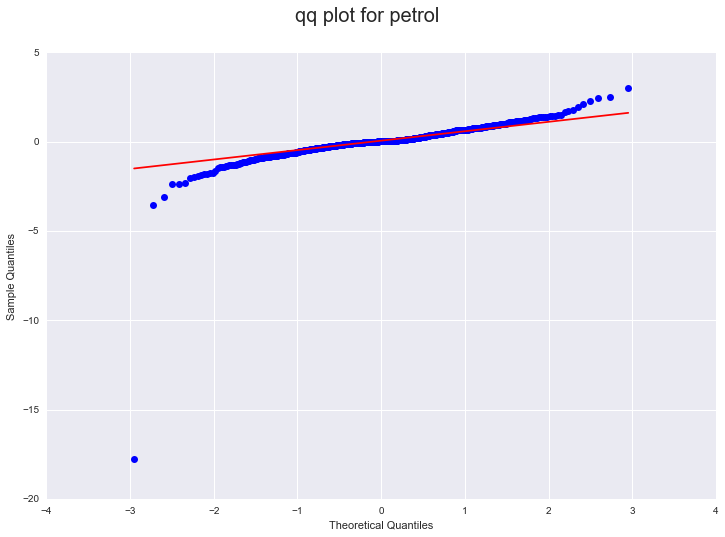

In [11]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig.suptitle('qq plot for petrol ', fontsize=20)
ax = qqplot(y_residPetrol,line='q',ax=ax,fit=True)

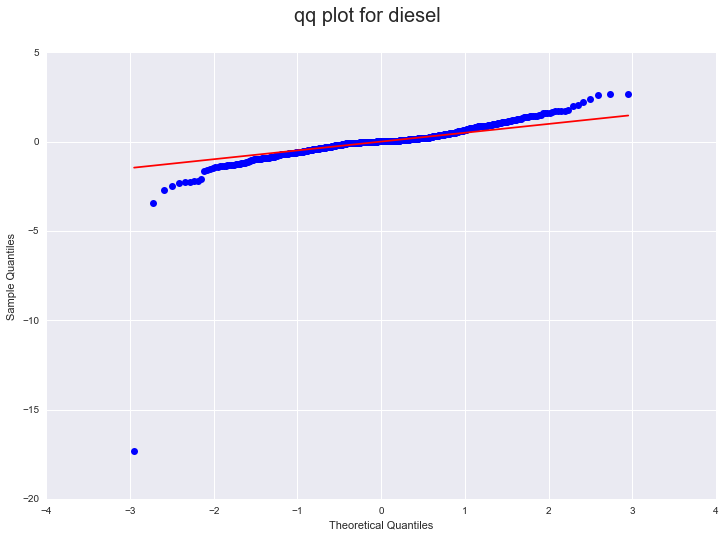

In [12]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig.suptitle('qq plot for diesel ', fontsize=20)
ax = qqplot(y_residDiesel,line='q',ax=ax,fit=True)

##### We can see the qq plot for diesel and petrol almost identitcal. Both qq plot shows that residual of the prediction and the actual value are very small. 

## Model Autocorrelation

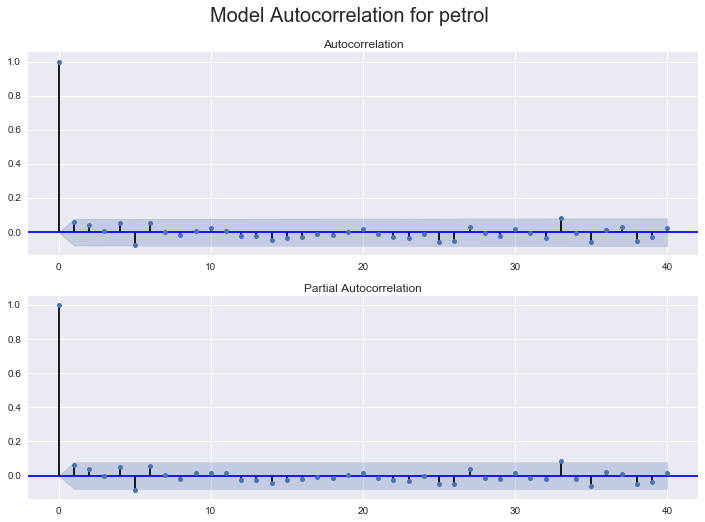

In [13]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Model Autocorrelation for petrol ', fontsize=20)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_residPetrol.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_residPetrol, lags=40, ax=ax2)

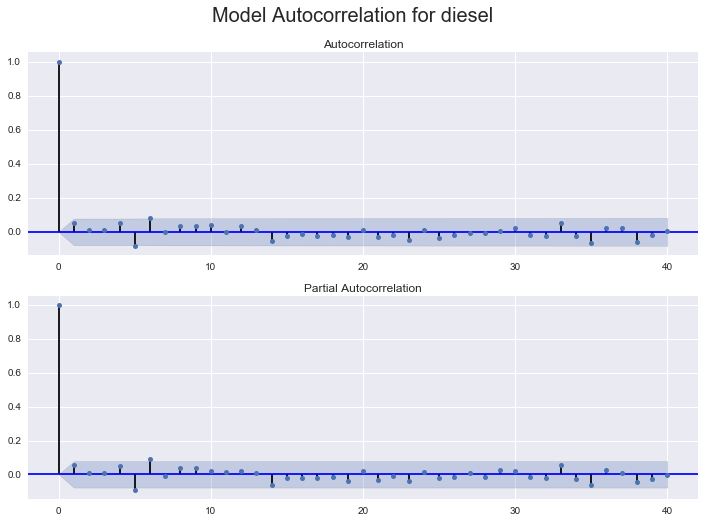

In [14]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Model Autocorrelation for diesel', fontsize=20)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_residDiesel.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_residDiesel, lags=40, ax=ax2)

##### By using log transformation ,the Autocorrelation plot has a spike on 1 and shine pattern after that, that means that  the autocorrelation of the prediction model works quite well. 

## Prediction 

We compute the prediction and analyze their fit against actual value.

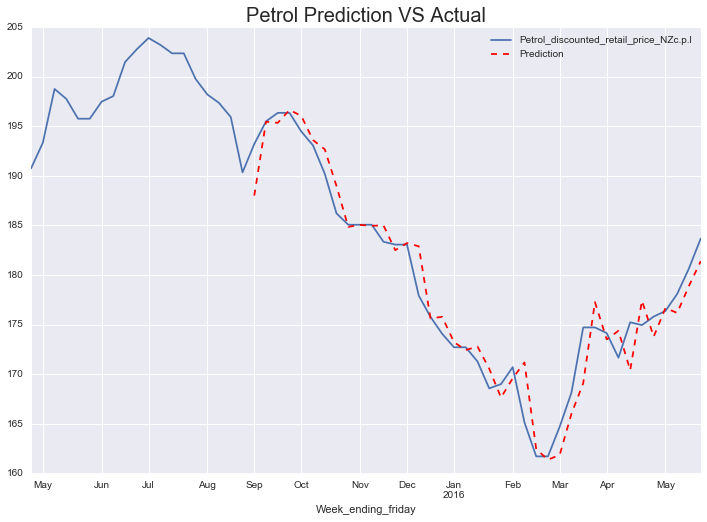

In [15]:
prdict_petrol=model_petrol.predict('2015-9-04','2016-5-27',dynamic=False)
prd_p=np.exp(prdict_petrol)
ax=ts_data_petrol.ix['2015-4-23':].plot(figsize=(12,8))
ax=prd_p.plot(ax=ax,style='r--',label='Prediction')
plt.title("Petrol Prediction VS Actual",size=20)
ax.legend()


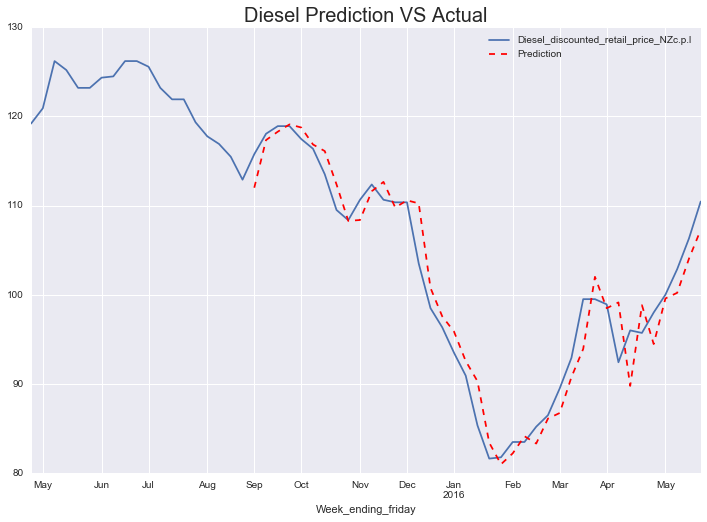

In [16]:
prdict_diesel=model_diesel.predict('2015-9-04','2016-5-27',dynamic=False)
prd_d=np.exp(prdict_diesel)

ax=ts_data_diesel.ix['2015-4-23':].plot(figsize=(12,8))
ax=prd_d.plot(ax=ax,style='r--',label='Prediction')
plt.title("Diesel Prediction VS Actual",size=20)
ax.legend()


The plot shows in generally the prediction fits the trend quite well enventhought there is some parts overfit.

## Calculate Forecast Error
Mean absolute error: The mean absolute error (MAE) value is computed as the average absolute error value. If this value is 0 (zero), the fit (forecast) is perfect. As compared to the mean squared error value, this measure of fit will “de-emphasize” outliers, that is, unique or rare large error values will affect the MAE less than the MSE value.

Mean Forecast Error (Bias). The mean forecast error (MFE) is the average error in the observations. A large positive MFE means that the forecast is undershooting the actual observations, and a large negative MFE means the forecast is overshooting the actual observations. A value near zero is ideal.

The MAE is a better indicator of fit than the MFE.



In [17]:
#Fucntion for Mean Forcast error:
def mean_forcast_err(y,yhat):
    return y.sub(yhat).mean()

In [18]:
#Function for Mean absolute erroe
def mean_absolute_err(y,yhat):
    return np.mean(np.abs(y.sub(yhat).mean()/yhat))

In [19]:
print "Petrol MFE=",mean_forcast_err(ts_data_petrol['Petrol_discounted_retail_price_NZc.p.l'],prd_p)
print "Petrol MAE=",mean_absolute_err(ts_data_petrol['Petrol_discounted_retail_price_NZc.p.l'],prd_p)
print "Diesel MFE=",mean_forcast_err(ts_data_diesel['Diesel_discounted_retail_price_NZc.p.l'],prd_d)
print "Diesel MAE=",mean_absolute_err(ts_data_diesel['Diesel_discounted_retail_price_NZc.p.l'],prd_d)

Petrol MFE= -0.0122373597993
Petrol MAE= 6.8728067745e-05
Diesel MFE= -0.0342935627418
Diesel MAE= 0.000343616492162


#### MFE slightly less than zero, model showed a little bit trend to over-forcast ,however it is between -4 to 4 range it means  model is working correctly.And MAE is significantly small it would indicate a prety good fit.

In [20]:
model_petrol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        ARMA Model Results                                        
==================================================================================================
Dep. Variable:     Petrol_discounted_retail_price_NZc.p.l   No. Observations:                  632
Model:                                         ARMA(1, 1)   Log Likelihood                1807.912
Method:                                           css-mle   S.D. of innovations              0.014
Date:                                    Fri, 03 Jun 2016   AIC                          -3607.823
Time:                                            10:40:20   BIC                          -3590.027
Sample:                                        04-23-2004   HQIC                         -3600.912
                                             - 05-27-2016                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------
const                                            5.0854      0.141     36.050      0.000         4.809     5.362
ar.L1.Petrol_discounted_retail_price_NZc.p.l     0.9955      0.004    281.589      0.000         0.989     1.002
ma.L1.Petrol_discounted_retail_price_NZc.p.l     0.4540      0.031     14.873      0.000         0.394     0.514
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0045           +0.0000j            1.0045            0.0000
MA.1           -2.2028           +0.0000j            2.2028            0.5000
-----------------------------------------------------------------------------
"""

In [21]:
model_diesel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        ARMA Model Results                                        
==================================================================================================
Dep. Variable:     Diesel_discounted_retail_price_NZc.p.l   No. Observations:                  632
Model:                                         ARMA(1, 1)   Log Likelihood                1614.460
Method:                                           css-mle   S.D. of innovations              0.019
Date:                                    Fri, 03 Jun 2016   AIC                          -3220.919
Time:                                            10:40:20   BIC                          -3203.123
Sample:                                        04-23-2004   HQIC                         -3214.008
                                             - 05-27-2016                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------
const                                            4.6590      0.170     27.363      0.000         4.325     4.993
ar.L1.Diesel_discounted_retail_price_NZc.p.l     0.9948      0.004    253.718      0.000         0.987     1.003
ma.L1.Diesel_discounted_retail_price_NZc.p.l     0.4252      0.032     13.222      0.000         0.362     0.488
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0052           +0.0000j            1.0052            0.0000
MA.1           -2.3519           +0.0000j            2.3519            0.5000
-----------------------------------------------------------------------------
"""

#### From above summary we can see that the mdoel_petrol fit well to the dataset. Because the Akaike information criterion(AIC), Bayesian information criterion(BIC) and Hannan–Quinn information criterion (HQIC) is quite small. 

## Conclusion 

According to all the test results and plots, it is clear that the ARMA model with log transformation is a good choice to use for predict the New Zealand retail petrol and diesel price. We are going to apply this model for our application that Prediction of fuel retail prices and an application that tells you if you should buy petrol at the current price or wait for a predicted price drop.